In [1]:
# data stuff:
import pandas as pd
import numpy as np
import optuna
from tqdm import tqdm

# modeling stuff:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# silence!
import warnings
warnings.filterwarnings("ignore")

---
### Forecasting with Random Forests:

See page 182 of "Advanced Forecasting with Python".

---

### Import data:

In [2]:
data = pd.read_csv('data/sunspots.csv', usecols=[1,2])
data.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


&nbsp;

### Feature Engineering:
We'll create date features using the original "Date" feature, as well as lagged variables up to a month (12 steps).

##### Date Features:

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['week'] = data['Date'].dt.week

In [4]:
data.head()

,Date,Monthly Mean Total Sunspot Number,year,month,week
0,1749-01-31,96.7,1749,1,5
1,1749-02-28,104.3,1749,2,9
2,1749-03-31,116.7,1749,3,14
3,1749-04-30,92.8,1749,4,18
4,1749-05-31,141.7,1749,5,22


##### Lagged features:

In [5]:
# define lagging function:
def get_lagged_features(df, lagvar, nlags):
    # iterate through number of lags:
    for lag in range(1, nlags+1):
        # set column name for new variable:
        col_name = 'lag_'+str(lag)
        # lag the original column:
        df[col_name] = df[lagvar].shift(lag)
    # drop nan values generated by the lag operation:
    df.dropna(inplace=True)
    
    return df

In [6]:
data = get_lagged_features(df=data, lagvar='Monthly Mean Total Sunspot Number', nlags=12)
data

,Date,Monthly Mean Total Sunspot Number,year,month,week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
12,1750-01-31,122.2,1750,1,5,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3,96.7
13,1750-02-28,126.5,1750,2,9,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3
14,1750-03-31,148.7,1750,3,14,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7
15,1750-04-30,147.2,1750,4,18,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8
16,1750-05-31,150.0,1750,5,22,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3247,2019-08-31,0.5,2019,8,35,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7
3248,2019-09-30,1.1,2019,9,40,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3
3249,2019-10-31,0.4,2019,10,44,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9
3250,2019-11-30,0.5,2019,11,48,0.4,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9


&nbsp;

### Prepare data for the model:

In [7]:
# set "Date" as the index:
data = data.set_index('Date')

# set predictor and target variables:
X = data.drop(['Monthly Mean Total Sunspot Number'], axis=1)
y = data['Monthly Mean Total Sunspot Number']

In [8]:
# split into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345, shuffle=False)

### Fit the model and evaluate:

In [9]:
# initialize random forest model:
my_rf = RandomForestRegressor()
my_rf.fit(X_train, y_train)

# predict:
fcst = my_rf.predict(X_test)

# evaluate:
r2_score(list(y_test), list(fcst))

0.8581185147453069

&nbsp;

### Perform Hyperparam optimization with Optuna:

In [10]:
def objective_rf(trial):
    # random forest params:
    max_features=trial.suggest_float("max_features", 0.2, 0.9, step=0.1)
    n_estimators=trial.suggest_int('n_estimators', 1, 50, step=1)
    max_depth=trial.suggest_int('max_depth', 1, 20, step=1)
    max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 50, step=1)
    min_samples_split=trial.suggest_float("min_samples_split", 0.01, 0.1, step=0.01)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 30, step=1)
    min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0.0, 0.2, step=0.05)
    min_weight_fraction_leaf=trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.05, step=0.005)

    # initialize model with trial vals:
    rf=RandomForestRegressor(max_features=max_features,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            max_leaf_nodes=max_leaf_nodes,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            min_impurity_decrease=min_impurity_decrease,
                            min_weight_fraction_leaf=min_weight_fraction_leaf)
    # fit
    rf.fit(X_train, y_train)

    # predict on the fold:
    preds = rf.predict(X_test)

    # obtain residuals and evaluate using r-squared:
    score = r2_score(y_test, preds)

    # delete fitted models after eval:
    del rf

    return score

In [11]:
# find optimal params (orders) that will maximize R-squared value:
study=optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=25)

[I 2022-06-09 12:45:44,696] A new study created in memory with name: no-name-8e3a9c29-2479-4e24-933a-c3c1d3195061
[I 2022-06-09 12:45:44,765] Trial 0 finished with value: 0.6987231766925801 and parameters: {'max_features': 0.5, 'n_estimators': 43, 'max_depth': 1, 'max_leaf_nodes': 50, 'min_samples_split': 0.05, 'min_samples_leaf': 16, 'min_impurity_decrease': 0.2, 'min_weight_fraction_leaf': 0.01}. Best is trial 0 with value: 0.6987231766925801.
[I 2022-06-09 12:45:44,928] Trial 1 finished with value: 0.8539162628519104 and parameters: {'max_features': 0.8, 'n_estimators': 35, 'max_depth': 7, 'max_leaf_nodes': 42, 'min_samples_split': 0.09999999999999999, 'min_samples_leaf': 25, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.05}. Best is trial 1 with value: 0.8539162628519104.
[I 2022-06-09 12:45:45,006] Trial 2 finished with value: 0.8629053900731152 and parameters: {'max_features': 0.4, 'n_estimators': 24, 'max_depth': 12, 'max_leaf_nodes': 11, 'min_samples_split': 0.04,

In [12]:
# optimal result and corresponding params:
trial=study.best_trial

# top r-squared value:
trial_value = np.round(trial.value, 2)

print(f"R-squared: {trial_value}")
print("best params for Random Forest: {}".format(trial.params))

R-squared: 0.87
best params for Random Forest: {'max_features': 0.4, 'n_estimators': 41, 'max_depth': 15, 'max_leaf_nodes': 37, 'min_samples_split': 0.06999999999999999, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.05, 'min_weight_fraction_leaf': 0.015}


&nbsp;

### Create final model and plot:

In [13]:
# initialize random forest model:
final_rf = RandomForestRegressor().set_params(**study.best_params)
final_rf.fit(X_train, y_train)

# predict:
final_fcst = final_rf.predict(X_test)

# evaluate:
final_score = np.round(r2_score(list(y_test), list(final_fcst)), 2)

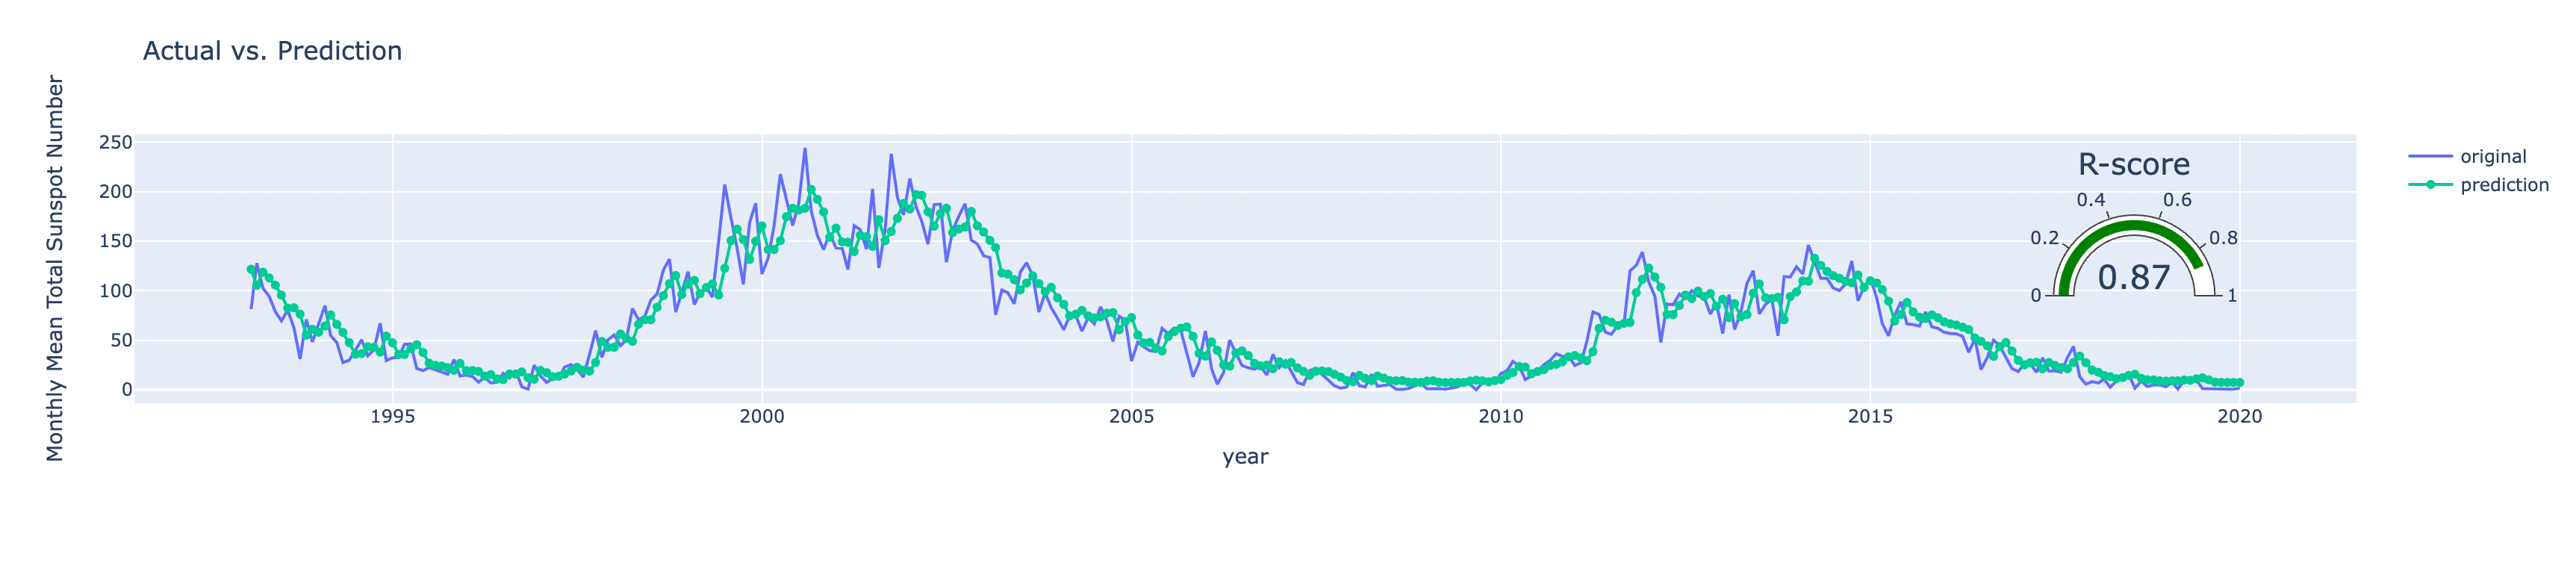

In [22]:
# plot:
fig = go.Figure()
# original
fig.add_trace(go.Scatter(x=list(y_test.index), y=y_test, mode='lines', name='original'))
fig.add_trace(go.Indicator(
    mode = "gauge+number",
    value = final_score,
    title = {'text': "R-score"},
    domain = {'x': [0.85, 0.95], 'y': [0.4, 0.7]},
    gauge = {'axis': {'range': [0, 1]}},
))
fig.update_layout(
    title="Actual vs. Prediction",
    xaxis_title="year",
    yaxis_title="Monthly Mean Total Sunspot Number")

# predicted:
fig.add_trace(go.Scatter(x=list(y_test.index), y=final_fcst, mode='lines+markers', name='prediction'))
Image(filename='./images/ch14_nocvfit.png', width=1800)

&nbsp;

### Optimization with Cross-Validation:


<div class="alert alert-block alert-warning">
<b>EXTRA:</b>
    
Below we repeat the hyperparam optimization but we use 10-fold cross validation to find the best values.
</div>

In [15]:
def objective_rf_cv(trial):
    # random forest params:
    max_features=trial.suggest_float("max_features", 0.1, 0.8, step=0.1)
    n_estimators=trial.suggest_int('n_estimators', 1, 50, step=1)
    max_depth=trial.suggest_int('max_depth', 1, 30, step=1)
    max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 50, step=1)
    min_samples_split=trial.suggest_float("min_samples_split", 0.01, 0.1, step=0.01)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 30, step=1)
    min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0.0, 0.2, step=0.05)
    min_weight_fraction_leaf=trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.05, step=0.005)

    # initialize model with trial vals:
    params = {'max_features': max_features,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'max_leaf_nodes': max_leaf_nodes,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'min_impurity_decrease': min_impurity_decrease,
              'min_weight_fraction_leaf': min_weight_fraction_leaf}
    
    # initialize:
    rf=RandomForestRegressor().set_params(**params)
    
    # obtain mean score for the folds:
    val_score = np.mean(cross_val_score(rf, X, y, cv=10))

    return val_score

In [16]:
# find optimal params (orders) that will maximize R-squared value:
study_cv=optuna.create_study(direction="maximize")
study_cv.optimize(objective_rf_cv, n_trials=50)

[I 2022-06-09 12:45:47,981] A new study created in memory with name: no-name-2090925b-e0b8-4ff4-b999-8bb6a4391190
[I 2022-06-09 12:45:48,197] Trial 0 finished with value: 0.7811710841393273 and parameters: {'max_features': 0.6, 'n_estimators': 5, 'max_depth': 8, 'max_leaf_nodes': 5, 'min_samples_split': 0.02, 'min_samples_leaf': 11, 'min_impurity_decrease': 0.05, 'min_weight_fraction_leaf': 0.03}. Best is trial 0 with value: 0.7811710841393273.
[I 2022-06-09 12:45:49,516] Trial 1 finished with value: 0.8213225506231115 and parameters: {'max_features': 0.4, 'n_estimators': 42, 'max_depth': 24, 'max_leaf_nodes': 13, 'min_samples_split': 0.04, 'min_samples_leaf': 23, 'min_impurity_decrease': 0.05, 'min_weight_fraction_leaf': 0.04}. Best is trial 1 with value: 0.8213225506231115.
[I 2022-06-09 12:45:51,155] Trial 2 finished with value: 0.8227602597774462 and parameters: {'max_features': 0.5, 'n_estimators': 43, 'max_depth': 20, 'max_leaf_nodes': 16, 'min_samples_split': 0.02, 'min_samples_

In [17]:
# optimal result and corresponding params:
trial_cv=study_cv.best_trial

# top r-squared value:
trial_value_cv = np.round(trial_cv.value, 2)

print(f"R-squared: {trial_value_cv}")
print("best params for Random Forest: {}".format(trial_cv.params))

R-squared: 0.83
best params for Random Forest: {'max_features': 0.5, 'n_estimators': 48, 'max_depth': 22, 'max_leaf_nodes': 46, 'min_samples_split': 0.01, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.15000000000000002, 'min_weight_fraction_leaf': 0.0}


&nbsp;

### Plot Optimization Study Trials:

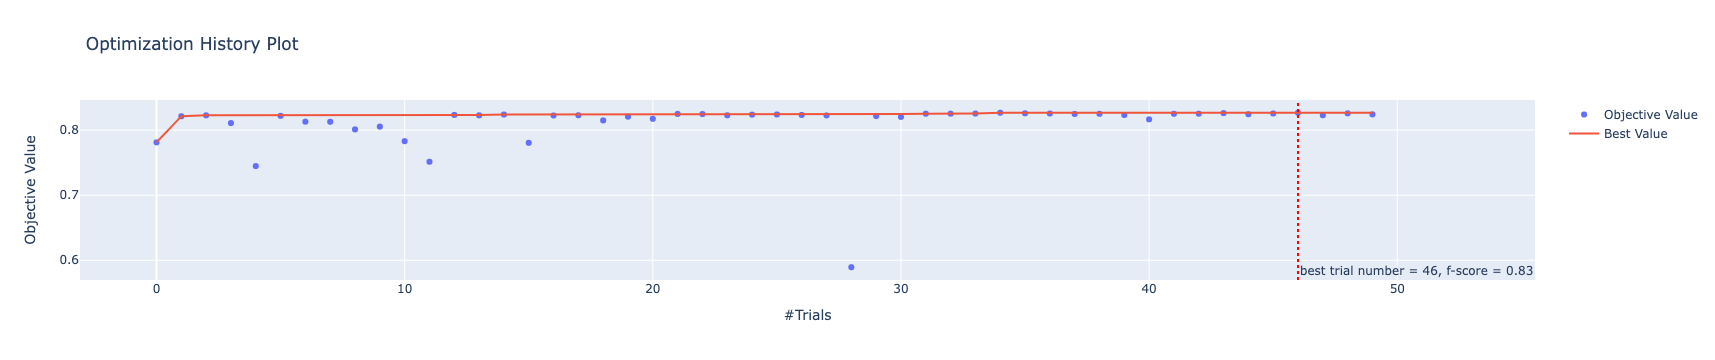

In [18]:
best_trial = study_cv.best_trial.number
best_trial_val = np.round(study_cv.best_trial.values[0], 2)
study_fig = optuna.visualization.plot_optimization_history(study_cv)
study_fig.add_vline(x=best_trial, line_dash="dot", line_color='red', annotation_text=f"best trial number = {best_trial}, f-score = {best_trial_val}", annotation_position="bottom right")
study_fig

### Build optimized model:

In [19]:
# initialize random forest model:
final_rf_cv = RandomForestRegressor().set_params(**study_cv.best_params)
final_rf_cv.fit(X_train, y_train)

# predict:
final_fcst_cv = final_rf_cv.predict(X_test)

# evaluate:
final_cv_score = np.round(r2_score(list(y_test), list(final_fcst_cv)), 2)

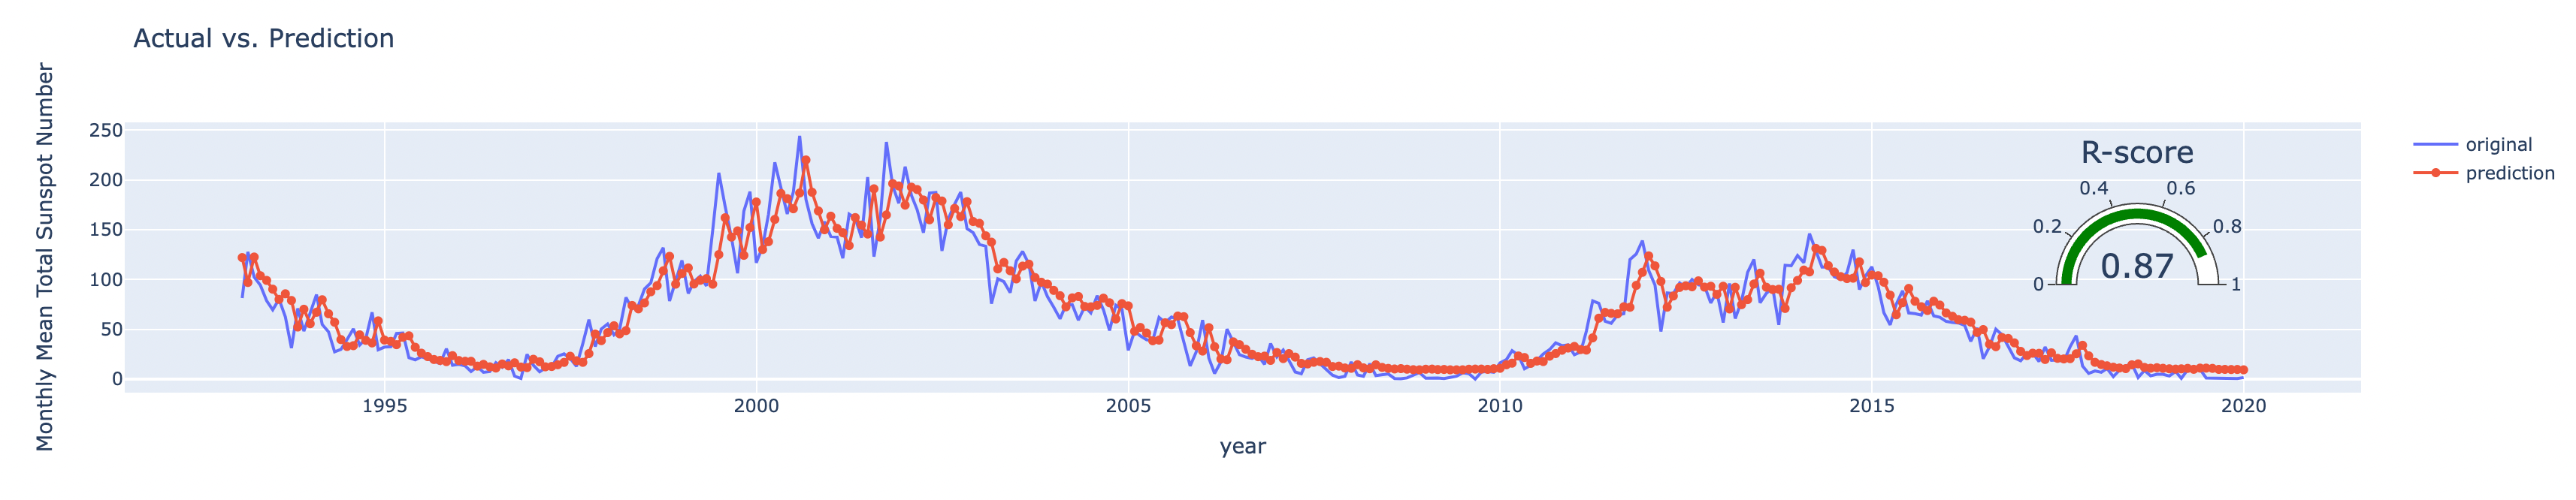

In [23]:
# plot:
fig = go.Figure()

# original
fig.add_trace(go.Scatter(x=list(y_test.index), y=y_test, mode='lines', name='original'))

# predicted:
fig.add_trace(go.Scatter(x=list(y_test.index), y=final_fcst_cv, mode='lines+markers', name='prediction'))
fig.add_trace(go.Indicator(
    mode = "gauge+number",
    value = final_cv_score,
    title = {'text': "R-score"},
    domain = {'x': [0.85, 0.95], 'y': [0.4, 0.7]},
    gauge = {'axis': {'range': [0, 1]}},
))
fig.update_layout(
    title="Actual vs. Prediction",
    xaxis_title="year",
    yaxis_title="Monthly Mean Total Sunspot Number")

Image(filename='./images/ch14_cvfit.png', width=1800)

### Get feature importance:

In [21]:
# obtain feature importance from regressor:
feat_importance = pd.DataFrame({'feature': X_train.columns, 'importance':  final_rf_cv.feature_importances_})
feat_importance.sort_values('importance', ascending=False)

,feature,importance
3,lag_1,0.493866
4,lag_2,0.234722
5,lag_3,0.125538
6,lag_4,0.093486
7,lag_5,0.024606
8,lag_6,0.007040
11,lag_9,0.005378
13,lag_11,0.002484
9,lag_7,0.002402
12,lag_10,0.002362


As we can see above, the first lagged value proved most important at the time of selecting the tree splits.